In [ ]:
import pandas as pd

path = "data/all_apps_wide_2026-01-28.csv"

df = pd.read_csv(
    path,
    sep=",",
)

#1. participant._current_page_name == results -> remove non experiment rows
mask = df['participant._current_page_name'] == 'Results'
df = df[mask]

#2. create dict of column names to access them easier
cols = {
    'comprehension_attempts': 'intro.1.player.comprehension_attempts',
    'choice': 'intro.1.group.retailer_choice',
    'payoff': 'experiment.1.player.payoff',
    'profit': 'experiment.1.player.profit',
    'role': 'participant.role'
}

#3. create column for total mistakes during comprehension check phase

def mistakes_per_comprehension_row(row):
    values = row.split(',')
    clean_values = [int(x.split(':')[1].strip().strip('}')) for x in values]
    corrected_values = [x-1 for x in clean_values]

    return sum(corrected_values)

df['defined.comprehension_mistakes'] = df[cols['comprehension_attempts']].apply(mistakes_per_comprehension_row)
cols['comprehension_mistakes'] = 'defined.comprehension_mistakes'

#4. create column for manager / employee distinction

df['defined.is_manager'] = df[cols['role']].str.contains('Manager', case=False)
cols['is_manager'] = 'defined.is_manager'

#5. create column to check for deal existence between two humans

df['defined.human_deal'] = df['experiment.1.player.price_accepted'].notna()
cols['human_deal'] = 'defined.human_deal'

#6. ensure that retailer and supplier config flags differ: 1/0 or 0/1

for index, row in df.iterrows():
    if row['session.config.force_retailer_first'] == row['session.config.force_supplier_first']:
        raise Exception('session.config.force_retailer_first = session.config.force_supplier_first | Random Assignment')

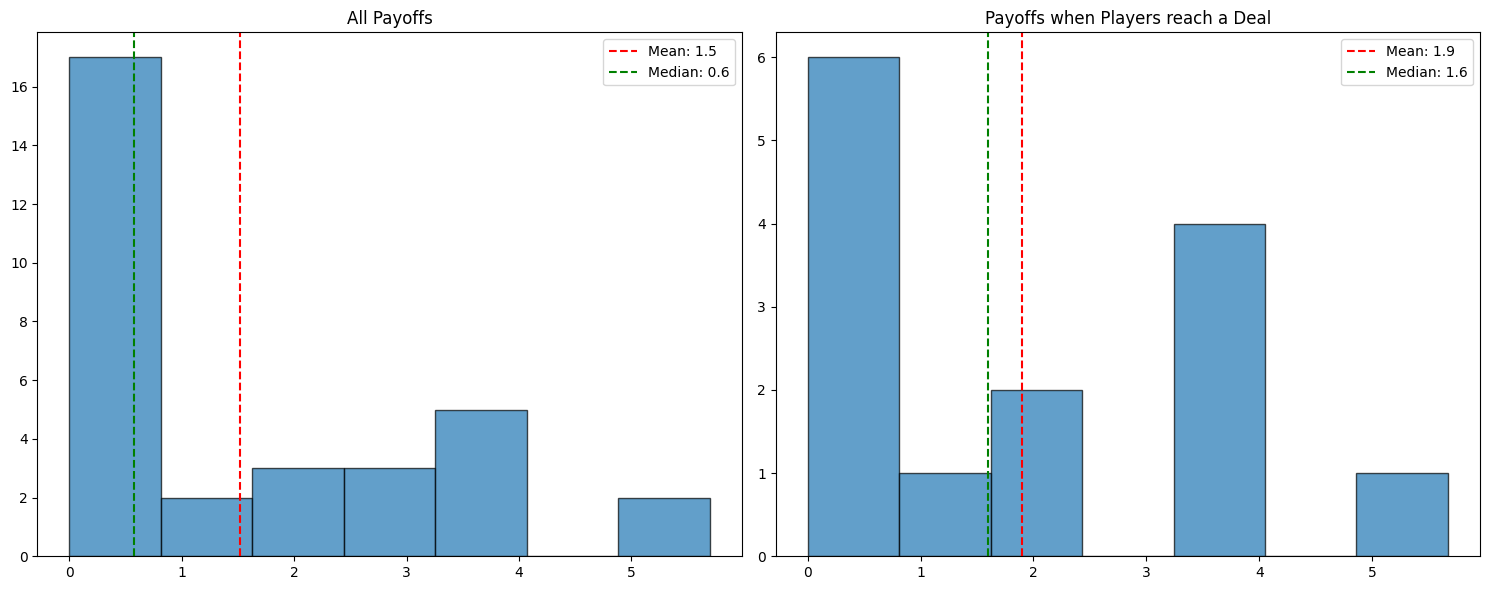

All payoffs:
 count    32.000000
mean      1.519687
std       1.796497
min       0.000000
25%       0.000000
50%       0.570000
75%       3.030000
max       5.700000
Name: experiment.1.player.payoff, dtype: float64

Human deals:
 count    14.000000
mean      1.902857
std       1.863650
min       0.000000
25%       0.210000
50%       1.595000
75%       3.282500
max       5.670000
Name: experiment.1.player.payoff, dtype: float64


In [58]:
import matplotlib.pyplot as plt
import numpy as np

payoff_col = df[cols['payoff']]
human_deal_mask = df[cols['human_deal']]
payoff_col_with_deal = payoff_col[human_deal_mask]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# All payoffs
ax1.hist(payoff_col, bins=7, edgecolor='black', alpha=0.7)
ax1.axvline(payoff_col.mean(), color='red', linestyle='--', 
            label=f'Mean: {payoff_col.mean():.1f}')
ax1.axvline(payoff_col.median(), color='green', linestyle='--', 
            label=f'Median: {payoff_col.median():.1f}')
ax1.set_title('All Payoffs')
ax1.legend()

# Payoffs when players reach a deal
ax2.hist(payoff_col_with_deal, bins=7, edgecolor='black', alpha=0.7)
ax2.axvline(payoff_col_with_deal.mean(), color='red', linestyle='--', 
            label=f'Mean: {payoff_col_with_deal.mean():.1f}')
ax2.axvline(payoff_col_with_deal.median(), color='green', linestyle='--', 
            label=f'Median: {payoff_col_with_deal.median():.1f}')
ax2.set_title('Payoffs when Players reach a Deal')
ax2.legend()

plt.tight_layout()
plt.show()

# Stats
print("All payoffs:\n", payoff_col.describe())
print("\nHuman deals:\n", payoff_col_with_deal.describe())


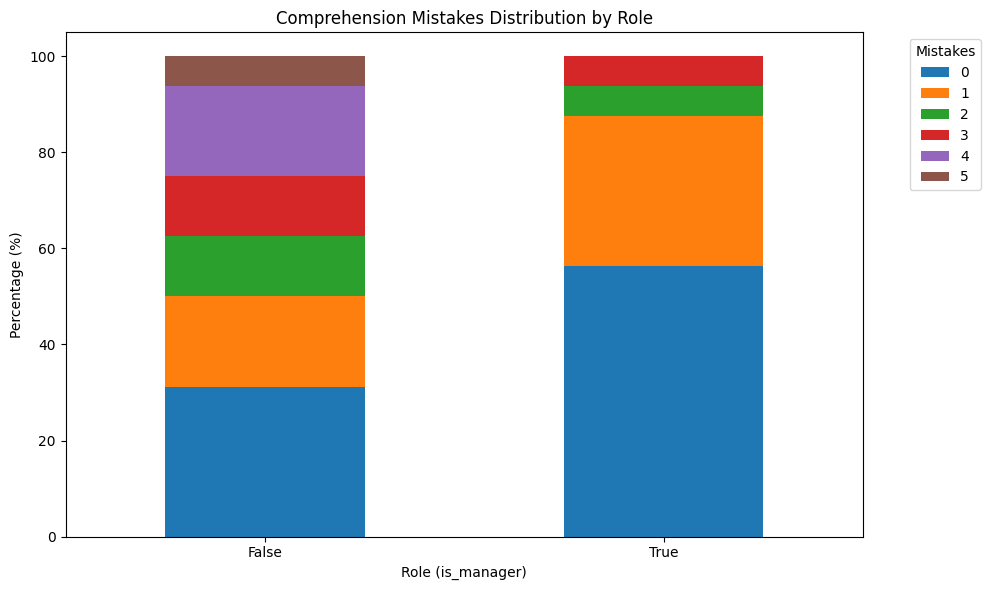

Stats by role:

                    count   mean       std  min  25%  50%   75%  max
defined.is_manager                                                  
False                16.0  1.875  1.746425  0.0  0.0  1.5  3.25  5.0
True                 16.0  0.625  0.885061  0.0  0.0  0.0  1.00  3.0

Raw counts:

defined.comprehension_mistakes  0  1  2  3  4  5
defined.is_manager                              
False                           5  3  2  2  3  1
True                            9  5  1  1  0  0


In [57]:
import matplotlib.pyplot as plt
import pandas as pd

mistakes_col = df[cols['comprehension_mistakes']]
role_col = df[cols['is_manager']]

# Stacked bar chart by role
ct = pd.crosstab(role_col, mistakes_col, normalize='index') * 100
ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.ylabel('Percentage (%)')
plt.xlabel('Role (is_manager)')
plt.title('Comprehension Mistakes Distribution by Role')
plt.legend(title='Mistakes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Stats by role
print("Stats by role:\n")
print(mistakes_col.groupby(role_col).describe())
print("\nRaw counts:\n")
print(pd.crosstab(role_col, mistakes_col))
